# Sample Model to Predict Taxi Cab Trip Time

##### This notebook will contain the model script to generate predictions for trip time to be used with the Kubeflow pipelines established. Any model can replace this one to illustrate the functionality of the MLOPS environment.

In [14]:
##load libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from io import BytesIO
from google.cloud import storage

In [15]:
##connect to training dataset
storage_client = storage.Client()
bucket = storage_client.get_bucket('mlops_model_input')
file = '/data_input/Taxi_Trips_3mo.csv'
blob = bucket.blob(file)
path = "gs://mlops_model_input" + file
df = pd.read_csv(path)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (10,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
##print the top 5 records of imported dataset
df.head()


,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,3e1ac82501797e2e6cd020d2eb6a47774add503f,51e37146cd6467734e50a00ffe2ebbb77ee35e5f207817...,01/01/2021 12:15:00 AM,01/01/2021 12:30:00 AM,"1,140",6.4,NaN,NaN,28.0,6.0,...,0.0,25.35,Credit Card,Medallion Leasin,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014)
1,3adf277e43154ac0cd099c7bb7137f75dcfded95,d24314a66ebc6319a50cc335d6896612b845ca15f702ee...,01/01/2021 12:15:00 AM,01/01/2021 12:15:00 AM,420,1.3,NaN,NaN,8.0,8.0,...,0.0,7.00,Cash,Top Cab Affiliation,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
2,352e025da59c35567204a5025d0a7ebbb41e7e93,67d5ca2736337fa9f349db0f29887fe290c0cd84263055...,01/01/2021 12:15:00 AM,01/01/2021 12:30:00 AM,660,4.7,NaN,NaN,7.0,3.0,...,0.0,14.25,Cash,Medallion Leasin,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
3,3276bc172c61ea58ce803d2f34611f6c074c14f1,35057a271731c5b976bda25efe85aa0c1901d0a5fc9ba2...,01/01/2021 12:15:00 AM,01/01/2021 12:15:00 AM,0,0.0,NaN,NaN,8.0,8.0,...,0.0,25.03,Credit Card,Chicago Independents,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
4,46e7d47c11aa83bc3488d7df84f901a92b961461,19e804a8eab9224b352e6a384007418b519864a3e7c2d9...,01/01/2021 12:15:00 AM,01/01/2021 12:15:00 AM,199,1.1,NaN,NaN,14.0,13.0,...,0.0,5.75,Cash,Medallion Leasin,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.983636,-87.723583,POINT (-87.7235831853 41.9836363072)


In [29]:
##check dimensions of imported file
rows = df.shape[0]
cols = df.shape[1]
print(rows)
print(cols)
print(df.dtypes)

511131
23
Trip ID                        object
Taxi ID                        object
Trip Start Timestamp           object
Trip End Timestamp             object
Trip Seconds                   object
Trip Miles                    float64
Pickup Census Tract           float64
Dropoff Census Tract          float64
Pickup Community Area         float64
Dropoff Community Area        float64
Fare                           object
Tips                          float64
Tolls                         float64
Extras                         object
Trip Total                     object
Payment Type                   object
Company                        object
Pickup Centroid Latitude      float64
Pickup Centroid Longitude     float64
Pickup Centroid Location       object
Dropoff Centroid Latitude     float64
Dropoff Centroid Longitude    float64
Dropoff Centroid  Location     object
dtype: object


####Our Model will use and try to predict the total number of Trip Seconds and we will set that to be the dependent variable

In [64]:
##null and missing value handling by removing null values
SELECTED_COLUMNS = ['Company','Pickup Community Area', 'Dropoff Community Area', 'Trip Seconds', 'Trip Miles']
print(df.isnull().sum())
df_filtered = df.dropna(axis=0, subset = SELECTED_COLUMNS) ##remove any rows with missing values
print(df_filtered.head())
print(df_filtered.shape[0])
print(df_filtered.shape[1])



Trip ID                            0
Taxi ID                          111
Trip Start Timestamp               0
Trip End Timestamp                94
Trip Seconds                     274
Trip Miles                         2
Pickup Census Tract           458925
Dropoff Census Tract          461650
Pickup Community Area          36709
Dropoff Community Area         60140
Fare                              59
Tips                              59
Tolls                             59
Extras                            59
Trip Total                        59
Payment Type                       0
Company                            0
Pickup Centroid Latitude       36571
Pickup Centroid Longitude      36571
Pickup Centroid Location       36571
Dropoff Centroid Latitude      59493
Dropoff Centroid Longitude     59493
Dropoff Centroid  Location     59493
dtype: int64
                                    Trip ID  \
0  3e1ac82501797e2e6cd020d2eb6a47774add503f   
1  3adf277e43154ac0cd099c7bb7137f75dcfded9

427073
23


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,3e1ac82501797e2e6cd020d2eb6a47774add503f,51e37146cd6467734e50a00ffe2ebbb77ee35e5f207817...,01/01/2021 12:15:00 AM,01/01/2021 12:30:00 AM,1140,6.40,NaN,NaN,28.0,6.0,...,0.0,25.35,Credit Card,Medallion Leasin,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014)
1,3adf277e43154ac0cd099c7bb7137f75dcfded95,d24314a66ebc6319a50cc335d6896612b845ca15f702ee...,01/01/2021 12:15:00 AM,01/01/2021 12:15:00 AM,420,1.30,NaN,NaN,8.0,8.0,...,0.0,7.00,Cash,Top Cab Affiliation,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
2,352e025da59c35567204a5025d0a7ebbb41e7e93,67d5ca2736337fa9f349db0f29887fe290c0cd84263055...,01/01/2021 12:15:00 AM,01/01/2021 12:30:00 AM,660,4.70,NaN,NaN,7.0,3.0,...,0.0,14.25,Cash,Medallion Leasin,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
4,46e7d47c11aa83bc3488d7df84f901a92b961461,19e804a8eab9224b352e6a384007418b519864a3e7c2d9...,01/01/2021 12:15:00 AM,01/01/2021 12:15:00 AM,199,1.10,NaN,NaN,14.0,13.0,...,0.0,5.75,Cash,Medallion Leasin,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.983636,-87.723583,POINT (-87.7235831853 41.9836363072)
5,68104156c9b7adfa21d0ae6293bad7fc2dd66e7c,2780ead18beaa862cc67315ddabd9d1acaadcd6da82eba...,01/01/2021 12:15:00 AM,01/01/2021 12:30:00 AM,741,1.85,NaN,NaN,2.0,1.0,...,0.0,9.25,Prcard,Flash Cab,42.001571,-87.695013,POINT (-87.6950125892 42.001571027),42.009623,-87.670167,POINT (-87.6701668569 42.0096228806)


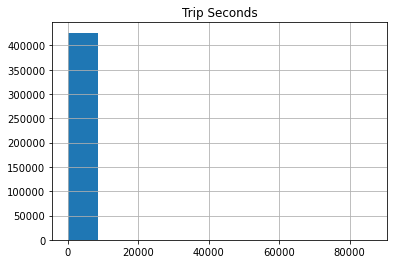

In [65]:
##histogram of dependent variable
#df["Trip Seconds"]=df["Trip Seconds"].astype(int)
df_filtered['Trip Seconds'] = df_filtered['Trip Seconds'].str.replace(',','').astype(int)
##remove observations with 0 trip seconds
df_filtered =df_filtered[df_filtered['Trip Seconds'] !=0]
df_filtered.hist(column='Trip Seconds')
print(df_filtered.shape[0])
print(df_filtered.shape[1])
df_filtered.head()


In [72]:
## create our training data sets with the independent vars. 
## X = Independent Vars: taxi cab company, pickup community area, and drop off community 
## Y = Var we are trying to predict : trip time in seconds

X_run_cols = df_filtered.columns.str.contains("pickup community area|dropoff community area|company|trip miles", case = False)
Y_col = df_filtered.columns.str.contains("trip seconds", case = False)
print(X_run_cols)
print(Y_col)
X = df_filtered.iloc[:, X_run_cols]
Y = df_filtered.iloc[:, Y_col]
print(X.head())
print(Y.head())


[False False False False False  True False False  True  True False False
 False False False False  True False False False False False False]
[False False False False  True False False False False False False False
 False False False False False False False False False False False]
   Trip Miles  Pickup Community Area  Dropoff Community Area  \
0        6.40                   28.0                     6.0   
1        1.30                    8.0                     8.0   
2        4.70                    7.0                     3.0   
4        1.10                   14.0                    13.0   
5        1.85                    2.0                     1.0   

               Company  
0     Medallion Leasin  
1  Top Cab Affiliation  
2     Medallion Leasin  
4     Medallion Leasin  
5            Flash Cab  
   Trip Seconds
0          1140
1           420
2           660
4           199
5           741


## Model Development Using Tensorflow

In [73]:
from pathlib import Path
import keras
import numpy
import tensorflow as tf

random_seed = 123
tf.random.set_seed(random_seed)
numpy.random.seed(random_seed)



In [74]:
##One step to split the original dataset in training and validation sets by random sampling
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, test_size=0.3)

In [ ]:
## The TF linear estimator uses both numeric and categorical features. 
## Feature columns work with all TensorFlow estimators and their purpose is to define the features used for modeling. 
## Additionally, they provide some feature engineering capabilities like one-hot-encoding, normalization, and bucketization.
## See tutorial : https://www.tensorflow.org/tutorials/estimator/linear

In [75]:
CATEGORICAL_COLUMNS = ['Company']
NUMERIC_COLUMNS = ['Pickup Community Area', 'Dropoff Community Area', 'Trip Miles']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = x_train[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [76]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(x_train, y_train)
eval_input_fn  = make_input_fn(x_test, y_test, num_epochs=1, shuffle=False)

In [77]:
## Train the model
## the model name is linear_est
linear_est = tf.estimator.LinearRegressor(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)
##remove null values, the error is related to that.
##estimater.predict will get the predictions


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp33x260u2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. 

In [79]:
result = linear_est.evaluate(eval_input_fn)
print(result)

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-05-11T19:18:19Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp33x260u2/model.ckpt-93430
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 3.57433s
INFO:tensorflow:Finished evaluation at 2021-05-11-19:18:23
INFO:tensorflow:Saving dict for global step 93430: average_loss = 3463980.5, g

In [ ]:
##Create model tf model object in bucket
##from keras.models import load_model
out_bucket = storage_client.get_bucket('mlops_model_out')
file_out   = 'sample_model'
linear_est.save("gs://mlops_model_input/" + file_out)